In [36]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import wave
import torch
import pandas as pd
from jupyterplot import ProgressPlot
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
torch.set_num_threads(1)
from sklearn import preprocessing

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"

plt.rcParams['figure.dpi'] = 300

# Loading File and its Framing from IEMOCAP

Sample Rate: 16000 Hz


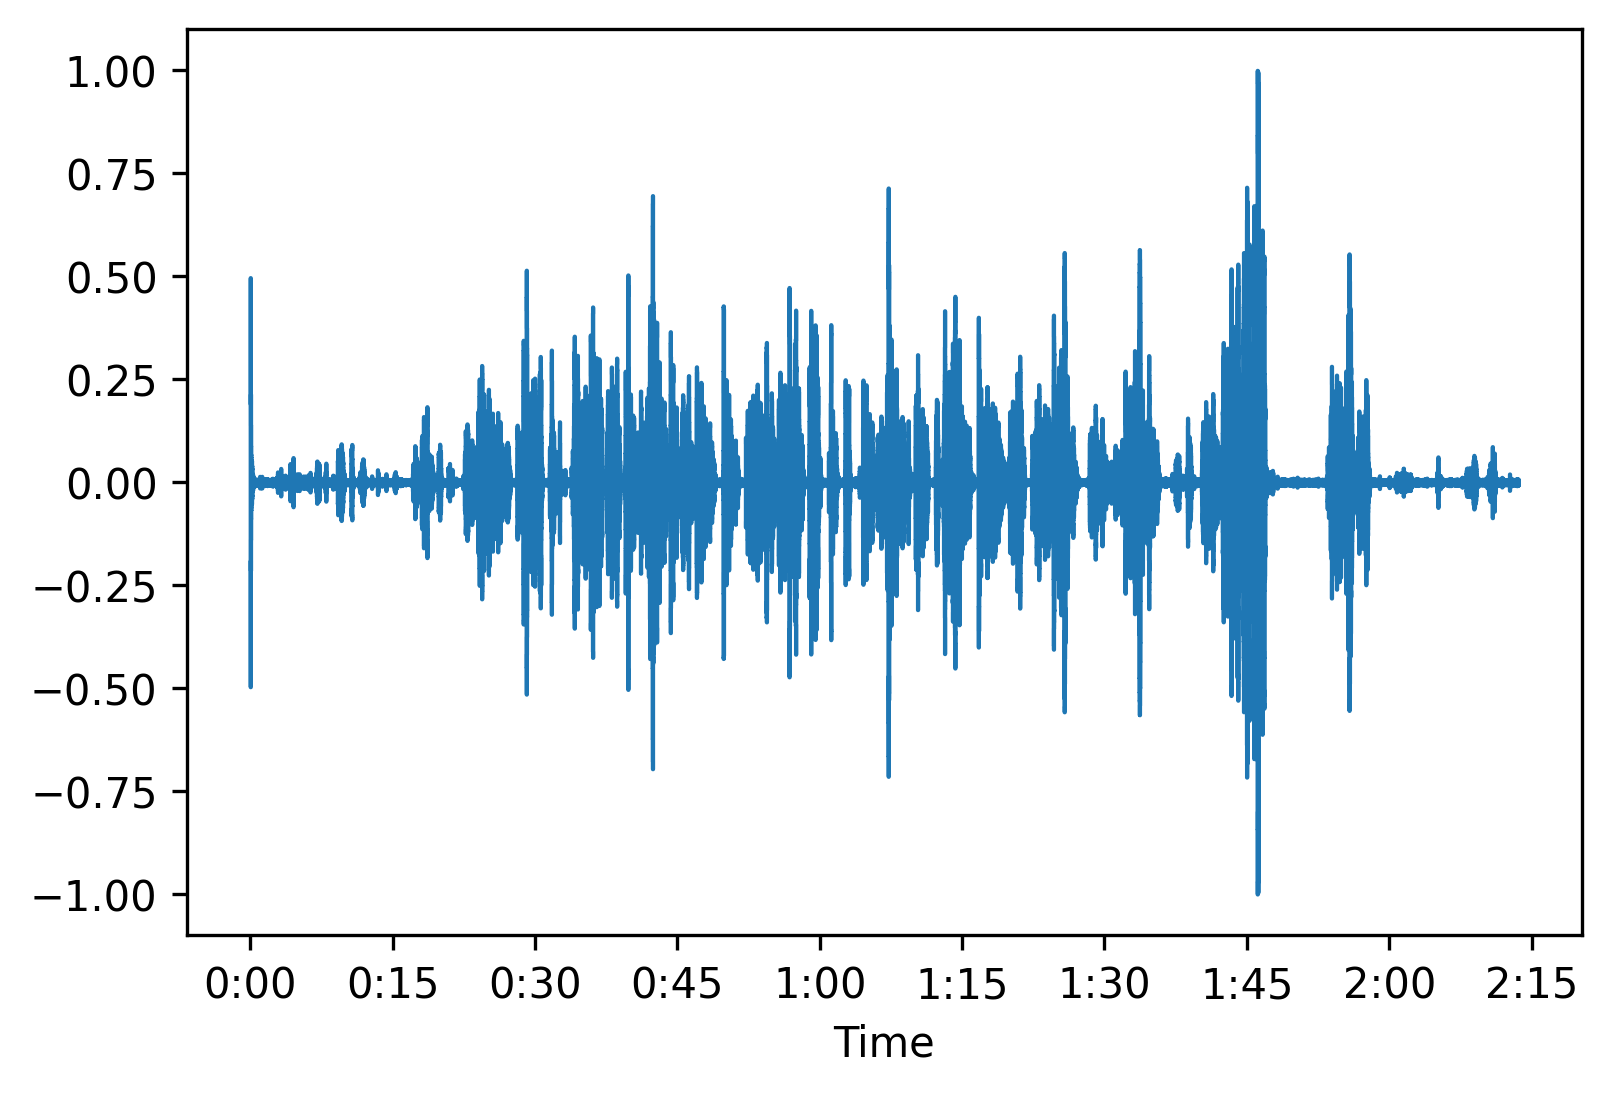

In [37]:
audio_file_test = AUDIO_DIR+'/Session1/dialog/wav/Ses01F_impro01.wav'
y, sr = librosa.load(audio_file_test, sr=16000)
y = preprocessing.minmax_scale(y, feature_range=(-1, 1))
librosa.display.waveshow(y, sr=sr)
print(f"Sample Rate: {sr} Hz")
plt.show()

In [38]:
def read_wav_part_from_local(path: str, start_s: float, duration_s: float):
    with wave.open(path, mode='rb') as wavread:
        fs = wavread.getframerate()
        start = int(start_s * fs)
        duration = int(duration_s * fs)
        wavread.setpos(start)
        wav_bytes = wavread.readframes(duration)
        
        if wavread.getsampwidth() == 2:
            dtype = 'int16'
        elif wavread.getsampwidth() == 4:
            dtype = 'int32'
        else:
            raise NotImplemented('Error Reading Sample')

        wav_array = np.frombuffer(wav_bytes, dtype=dtype)
        return wav_array, fs


def int2float32(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/abs_max
    sound = sound.squeeze()
    return sound


model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=False)


STEP = 0.03
MIN_CONFIDENCE = 0.7
MIN_SEGMENT_DURATION = 1
MAX_SEGMENT_DURATION = 5

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


# Framing

In [39]:
pp = ProgressPlot(plot_names=["Silero VAD"], line_names=["speech probabilities"], x_label="audio chunks")

frames = []

prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), STEP):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, STEP)
    if len(wav_array) == 960:
        confidence = model(torch.from_numpy(int2float32(wav_array)), fs).item()

        pp.update(confidence)

        end = start+STEP

        if confidence >= MIN_CONFIDENCE:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= MIN_SEGMENT_DURATION:
                prev_end = end
            else:
                if prev_end - prev_start >= MIN_SEGMENT_DURATION:
                    frames.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(frames) and frames[-1] != (prev_start, prev_end)) or ((not len(frames)) and prev_end):
    if prev_end - prev_start >= MIN_SEGMENT_DURATION:
        frames.append((prev_start, prev_end))

<IPython.core.display.Javascript object>

# Segmentation (Windowing) while Framing
Using Silero VAD

In [40]:
pp = ProgressPlot(plot_names=["Silero VAD"], line_names=["speech probabilities"], x_label="audio chunks")

segments = []

prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), STEP):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, STEP)
    if len(wav_array) == 960:
        confidence = model(torch.from_numpy(int2float32(wav_array)), fs).item()

        pp.update(confidence)

        end = start+STEP

        if confidence >= MIN_CONFIDENCE:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= MIN_SEGMENT_DURATION:
                prev_end = end
                if prev_end - prev_start >= MAX_SEGMENT_DURATION:
                    segments.append((prev_start, prev_end))
                    prev_start, prev_end = None, None
            else:
                if prev_end - prev_start >= MIN_SEGMENT_DURATION:
                    segments.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(segments) and segments[-1] != (prev_start, prev_end)) or ((not len(segments)) and prev_end):
    if prev_end - prev_start > MIN_SEGMENT_DURATION:
        segments.append((prev_start, prev_end))

<IPython.core.display.Javascript object>

## Checking Segments Duration

In [41]:
pd.DataFrame([y - x for x,y in segments]).describe()

,0
count,23.000000
mean,4.269130
std,1.323233
min,1.020000
25%,3.375000
50%,5.010000
75%,5.055000
max,5.490000


# Results Overview

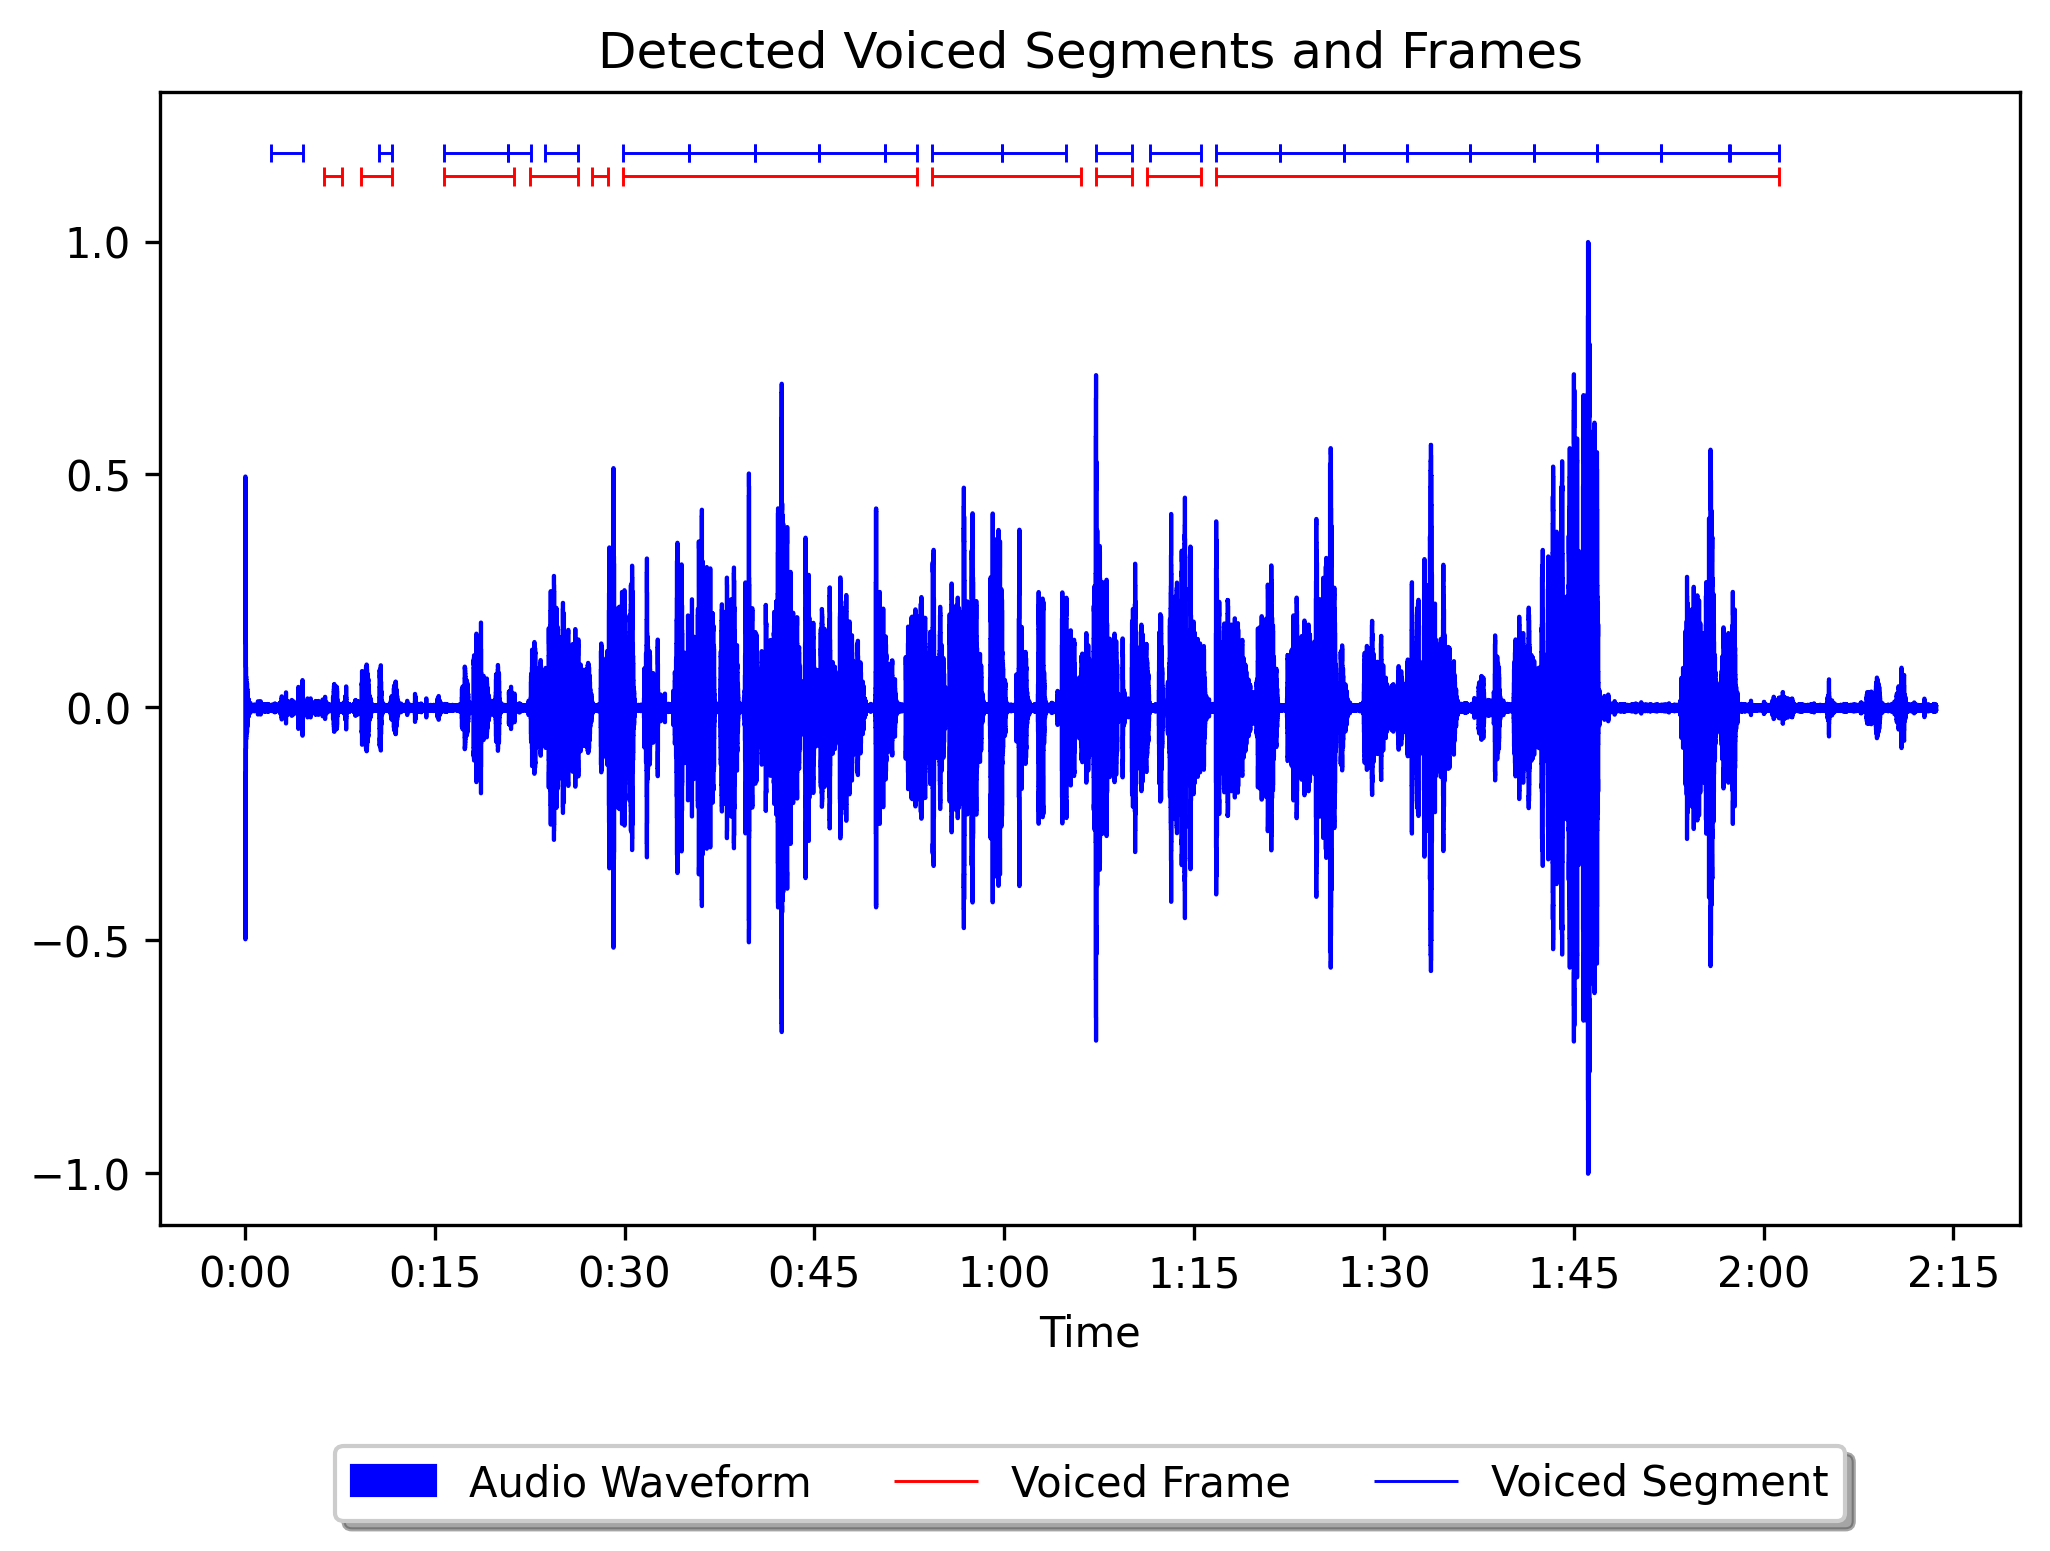

In [42]:
grid = plt.GridSpec(1, 1, wspace=.1, hspace=.1)
plt.figure(figsize=(8, 5))

ax = plt.subplot(grid[0, 0])
ax.set_title("Detected Voiced Segments and Frames")
y_len = np.max(y) * 0.02
y_space = np.max(y) * 0.1
upper_y, middle_y, lower_y = np.max(y)+ y_space + y_len*3, np.max(y)+ y_space + y_len*2, np.max(y)+ y_space + y_len

librosa.display.waveshow(y, sr=sr, label="Audio Waveform", color="blue")

start, end = frames[0]
ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red', label="Voiced Frame")
ax.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
ax.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in frames[1:]:
    ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red')
    ax.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    ax.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)

y_space = np.max(y) * 0.15
upper_y, middle_y, lower_y = np.max(y)+ y_space + y_len*3, np.max(y)+ y_space + y_len*2, np.max(y)+ y_space + y_len

start, end = segments[0]
ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue', label="Voiced Segment")
ax.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
ax.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in segments[1:]:
    ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue')
    ax.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
    ax.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)

ax.legend(loc='lower center', bbox_to_anchor=(.5, -.28),
    ncol=3, fancybox=True, shadow=True)

plt.show()